In [1]:
# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# import os
# for dirname, _, filenames in os.walk('../combined-real-and-fake-faces/combined-real-vs-fake/'):
#     for filename in filenames[:1]:
#         print(os.path.join(dirname, filename))


**Load Required Packages**

In [2]:
## Dowload packages
# !pip install --user keras-vggface
# !pip install --user opencv-python

In [3]:
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import metrics

from keras_vggface.vggface import VGGFace
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks.callbacks import ReduceLROnPlateau

from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


**Load Images**

In [4]:
base_path = '../combined-real-and-fake-faces/combined-real-vs-fake/'
image_gen = ImageDataGenerator(rescale=1./255.)
batch_size = 64

train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

valid_flow = image_gen.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

test_flow = image_gen.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 21591 images belonging to 2 classes.


In [5]:
train_flow.class_indices

{'fake': 0, 'real': 1}

In [6]:
valid_flow.class_indices

{'fake': 0, 'real': 1}

In [7]:
test_flow.class_indices

{'fake': 0, 'real': 1}

**Helper Functions**

In [8]:
"""
Plot the training and validation loss
epochs - list of epoch numbers
loss - training loss for each epoch
val_loss - validation loss for each epoch
"""
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    
"""
Plot the training and validation accuracy
epochs - list of epoch numbers
acc - training accuracy for each epoch
val_acc - validation accuracy for each epoch
"""
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

**Fine Tune VGGFace Model**

In [9]:
vgg_model = VGGFace(include_top=False, input_shape = (224,224,3))

last_layer = vgg_model.get_layer('pool5').output
flat_layer = Flatten(name='flatten')(last_layer)
fc1 = Dense(2048, activation='relu', name='fc1')(flat_layer)
dense2 = Dense(1, activation='sigmoid', name='dense2')(fc1)

custom_vgg_model = Model(vgg_model.input, dense2)

In [10]:
custom_vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [11]:
custom_vgg_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002), 
    metrics=['acc']
)

In [12]:
train_steps = 100000//batch_size
valid_steps = 20000//batch_size

history = custom_vgg_model.fit_generator(
    train_flow,
    epochs=5,
    steps_per_epoch=train_steps,
    validation_data=valid_flow,
    validation_steps=valid_steps
)

Epoch 1/5
1562/1562 [==============================] - 2711s 2s/step - loss: 0.2014 - acc: 0.9101 - val_loss: 0.0475 - val_acc: 0.9742
Epoch 2/5
1562/1562 [==============================] - 2679s 2s/step - loss: 0.0503 - acc: 0.9819 - val_loss: 0.0927 - val_acc: 0.9829
Epoch 3/5
1562/1562 [==============================] - 2674s 2s/step - loss: 0.0295 - acc: 0.9893 - val_loss: 0.0112 - val_acc: 0.9853
Epoch 4/5
1562/1562 [==============================] - 2672s 2s/step - loss: 0.0221 - acc: 0.9923 - val_loss: 0.0031 - val_acc: 0.9875
Epoch 5/5
1562/1562 [==============================] - 2668s 2s/step - loss: 0.0173 - acc: 0.9937 - val_loss: 0.0739 - val_acc: 0.9808


In [13]:
custom_vgg_model.save('vggface_v1.h5')

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

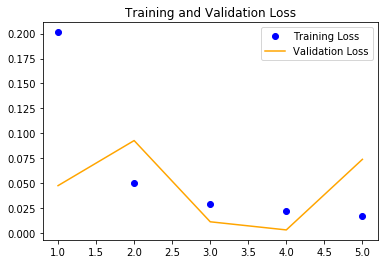

In [15]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)

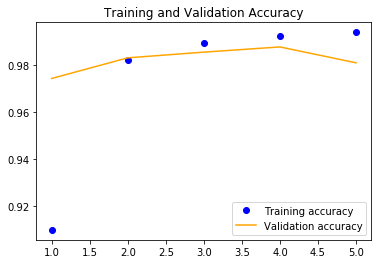

In [16]:
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

In [17]:
y_pred = custom_vgg_model.predict(test_flow)
y_test = test_flow.classes

In [18]:
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC-AUC Score: 0.9600932210254477
AP Score: 0.9325796549056171

              precision    recall  f1-score   support

           0       0.97      0.92      0.94     10735
           1       0.93      0.97      0.95     10856

    accuracy                           0.95     21591
   macro avg       0.95      0.95      0.95     21591
weighted avg       0.95      0.95      0.95     21591

